# Featurizing the dataset with MatterVial (part 2)

This notebook goes through the main functions and objects implemented in the MatterVial package. Based on a dataset containing ~4,000 entries of type (mp_id, structure, refractive index) taken from the MaterialsProject (MP). 
We continue the evaluation now introducing the ORB-v3 features, for that we need to use a different environment from the primary one. We will also introduce the effects of using recursive feature elimination for feature selection.

## 1. Loading the dataset

In this example the dataset is a dataframe saved as a csv, where the pymatgen structures are saved as json dumps.

In [3]:
import pandas as pd
import json
from pymatgen.core import Structure

# --- Step 1: Load the CSV file containing JSON strings ---
file_path = 'data/df_ref_index.csv'
df = pd.read_csv(file_path, index_col=0)
print(f"Loaded {len(df)} records from {file_path}")

# --- Step 2: Convert JSON strings back to Structure objects ---
# We use json.loads to parse the string, then Structure.from_dict
print("Reconstructing Structure objects from JSON...")
df['structure'] = df['structure'].apply(
    lambda json_string: Structure.from_dict(json.loads(json_string))
)
# --- Step 3: Verification ---
print("✅ Reconstruction complete!")
print("First few datapoints:")
df.head()


Loaded 4022 records from data/df_ref_index.csv
Reconstructing Structure objects from JSON...
✅ Reconstruction complete!
First few datapoints:


,structure,ref_index
mp-624234,"[[0.67808954 1.32800354 5.90141888] Te, [1.500...",2.440483
mp-560478,"[[-0.62755181 6.55361247 9.268476 ] Ba, [4....",1.790685
mp-556346,"[[4.43332093 4.12714801 8.8721209 ] Pr, [ 1.40...",2.056131
mp-13676,"[[-0.14481557 3.41229366 4.12618551] O, [3.2...",2.023772
mp-7610,"[[ 0.12549448 3.01287591 -0.20434955] Li, [1....",1.745509


## 2. Import the featurizers 
### (use orb_env.yml)


From `ORBFeaturizer`:
- `orb_v3`: ORB Featurizer version 3

We will apply these featurizers to our dataset and generate feature sets that will be used for training and evaluating machine learning models.

In [ ]:
## Code to generate the features, might take a while
## if not using GPU acceleration. Consider using the
## pre-generated features in the data folder. 
## In that case, skip to the next cell.

# # Uncomment to run yourself:
# from mattervial.featurizers.structure import ORBFeaturizer
# orb_v3 = ORBFeaturizer(model_name="ORB_v3")
# orb_features = orb_v3.get_features(df['structure'])

# orb_features.to_csv('./data/ref_index_features_orbv3.csv')

In [28]:
# Load orb features and align their index to df (if lengths match)
orb_features = pd.read_csv('./data/ref_index_features_orbv3.csv', index_col=0)

if len(orb_features) == len(df):
   # If the file index appears positional or doesn't match df, overwrite with df.index
   if isinstance(orb_features.index, pd.RangeIndex) or not orb_features.index.isin(df.index).all():
      orb_features.index = df.index
      print("Reindexed orb_features to match df.index")
   else:
      # If indexes already look like mp-ids but we want exact ordering of df
      orb_features = orb_features.reindex(df.index)
      print("Reordered/aligned orb_features to df.index")
else:
   raise ValueError(f"Cannot align indexes: orb_features has {len(orb_features)} rows but df has {len(df)} rows.")

# quick check
print("orb_features shape:", orb_features.shape)
orb_features.head()
## lets save the modified
orb_features.to_csv('./data/ref_index_features_orbv3.csv')

# orb_features = pd.read_csv('./data/ref_index_features_orbv3.csv', index_col=0)

Reindexed orb_features to match df.index
orb_features shape: (4022, 1792)


### (b) Test the different feature sets for prediction
We use scikit-learn models and XGBoost to evaluate the prediction performance of various feature combinations. 

In [29]:
## We need to separate in train and test
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [31]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import joblib

# Load the feature dataframes
features_l_mm = pd.read_csv('./data/ref_index_features_l_mm.csv', index_col=0)
features_l_ofm = pd.read_csv('./data/ref_index_features_l_ofm.csv', index_col=0)
features_mvl = pd.read_csv('./data/ref_index_features_mvl.csv', index_col=0)
adjmegnet_features = pd.read_csv('./data/ref_index_features_adjmegnet.csv', index_col=0)
roost_gap_features = pd.read_csv('./data/ref_index_features_roost_gap.csv', index_col=0)
roost_eform_features = pd.read_csv('./data/ref_index_features_roost_eform.csv', index_col=0)
orb_features = pd.read_csv('./data/ref_index_features_orbv3.csv', index_col=0)

# Naming convention for adj_megnet layers is incorrect, correcting it.
orb_features_initial = orb_features.filter(like='ORB_v3_initial_atom_embedding')
orb_features_layer_1 = orb_features.filter(like='ORB_v3_layer_1')
orb_features_layer_2 = orb_features.filter(like='ORB_v3_layer_2')
orb_features_layer_3 = orb_features.filter(like='ORB_v3_layer_3')
orb_features_layer_4 = orb_features.filter(like='ORB_v3_layer_4')
orb_features_layer_5 = orb_features.filter(like='ORB_v3_layer_5')



feature_combinations = {
    'MEGNet/ROOST (l_MM_v1 + l_OFM_v1 + mvl + adj_megnet + roost_gap + roost_eform)': [features_l_mm, features_l_ofm, features_mvl, adjmegnet_features, roost_gap_features, roost_eform_features],
    'ORBv3 Initial': [ orb_features_initial],
    'ORBv3 Layer 1': [ orb_features_layer_1],
    'ORBv3 Layer 2': [ orb_features_layer_2],
    'ORBv3 Layer 3': [ orb_features_layer_3],
    'ORBv3 Layer 4': [ orb_features_layer_4],
    'ORBv3 Layer 5': [orb_features_layer_5],
    'ORBv3': [orb_features],
    'MEGNet/ROOST + ORBv3': [features_l_mm, features_l_ofm, features_mvl, adjmegnet_features, roost_gap_features, roost_eform_features, orb_features],
}
# Ensure models folder exists
os.makedirs('./models', exist_ok=True)

# Prepare records list
metrics_records = []

# Use pre-split train_df and test_df from the notebook
y_train_global = train_df['ref_index']
y_test_global = test_df['ref_index']

for combination_name, feature_dfs in feature_combinations.items():
    print(f'Processing combination: {combination_name}')
    # Concatenate features (align on index)
    X_all = pd.concat(feature_dfs, axis=1)
    
    # Ensure we only use rows present in train/test (align by index)
    X_train = X_all.reindex(train_df.index)
    X_test = X_all.reindex(test_df.index)
    
    # Use the already-split targets
    y_train = y_train_global
    y_test = y_test_global

    # Fit model on training set
    model = XGBRegressor(objective='reg:squarederror', random_state=42)
    model.fit(X_train.values, y_train.values)  # pass numpy arrays to avoid index/column issues

    # Predictions for train and test
    y_train_pred = model.predict(X_train.values)
    y_test_pred = model.predict(X_test.values)

    # Train metrics
    mae_train = mean_absolute_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)

    # Test metrics
    mae_test = mean_absolute_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_test = r2_score(y_test, y_test_pred)

    # Save (register) model to disk with a sanitized filename
    safe_name = re.sub(r'[^0-9A-Za-z_]+', '_', combination_name)
    model_path = f'./models/xgb_{safe_name}.joblib'
    joblib.dump(model, model_path)

    # Record metrics
    metrics_records.append({
        'Combination': combination_name,
        'MAE_train': mae_train,
        'RMSE_train': rmse_train,
        'R2_train': r2_train,
        'MAE_test': mae_test,
        'RMSE_test': rmse_test,
        'R2_test': r2_test,
        'ModelPath': model_path
    })

    print(f"Train -> MAE: {mae_train:.4f}, RMSE: {rmse_train:.4f}, R2: {r2_train:.4f}")
    print(f"Test  -> MAE: {mae_test:.4f}, RMSE: {rmse_test:.4f}, R2: {r2_test:.4f}")
    print(f"Model saved to: {model_path}")
    print('-' * 60)

# Create metrics DataFrame
metrics_df = pd.DataFrame(metrics_records)
metrics_df

Processing combination: MEGNet/ROOST (l_MM_v1 + l_OFM_v1 + mvl + adj_megnet + roost_gap + roost_eform)
Train -> MAE: 0.0019, RMSE: 0.0024, R2: 1.0000
Test  -> MAE: 0.0671, RMSE: 0.1213, R2: 0.9200
Model saved to: ./models/xgb_MEGNet_ROOST_l_MM_v1_l_OFM_v1_mvl_adj_megnet_roost_gap_roost_eform_.joblib
------------------------------------------------------------
Processing combination: ORBv3 Initial
Train -> MAE: 0.0102, RMSE: 0.0329, R2: 0.9940
Test  -> MAE: 0.1096, RMSE: 0.1866, R2: 0.8109
Model saved to: ./models/xgb_ORBv3_Initial.joblib
------------------------------------------------------------
Processing combination: ORBv3 Layer 1
Train -> MAE: 0.0050, RMSE: 0.0067, R2: 0.9997
Test  -> MAE: 0.0739, RMSE: 0.1535, R2: 0.8721
Model saved to: ./models/xgb_ORBv3_Layer_1.joblib
------------------------------------------------------------
Processing combination: ORBv3 Layer 2
Train -> MAE: 0.0031, RMSE: 0.0041, R2: 0.9999
Test  -> MAE: 0.0767, RMSE: 0.1468, R2: 0.8829
Model saved to: ./mo

,Combination,MAE_train,RMSE_train,R2_train,MAE_test,RMSE_test,R2_test,ModelPath
0,MEGNet/ROOST (l_MM_v1 + l_OFM_v1 + mvl + adj_m...,0.001861,0.002439,0.999967,0.067068,0.121336,0.920033,./models/xgb_MEGNet_ROOST_l_MM_v1_l_OFM_v1_mvl...
1,ORBv3 Initial,0.010215,0.032858,0.994037,0.109649,0.186585,0.810906,./models/xgb_ORBv3_Initial.joblib
2,ORBv3 Layer 1,0.005041,0.006732,0.999750,0.073882,0.153470,0.872071,./models/xgb_ORBv3_Layer_1.joblib
3,ORBv3 Layer 2,0.003138,0.004121,0.999906,0.076690,0.146847,0.882873,./models/xgb_ORBv3_Layer_2.joblib
4,ORBv3 Layer 3,0.002817,0.003800,0.999920,0.095394,0.178856,0.826247,./models/xgb_ORBv3_Layer_3.joblib
5,ORBv3 Layer 4,0.003138,0.004181,0.999903,0.086527,0.181092,0.821874,./models/xgb_ORBv3_Layer_4.joblib
6,ORBv3 Layer 5,0.037052,0.050409,0.985966,0.199453,0.325233,0.425465,./models/xgb_ORBv3_Layer_5.joblib
7,ORBv3,0.001671,0.002227,0.999973,0.070231,0.137226,0.897718,./models/xgb_ORBv3.joblib
8,MEGNet/ROOST + ORBv3,0.001423,0.001861,0.999981,0.058915,0.117648,0.924821,./models/xgb_MEGNet_ROOST_ORBv3.joblib


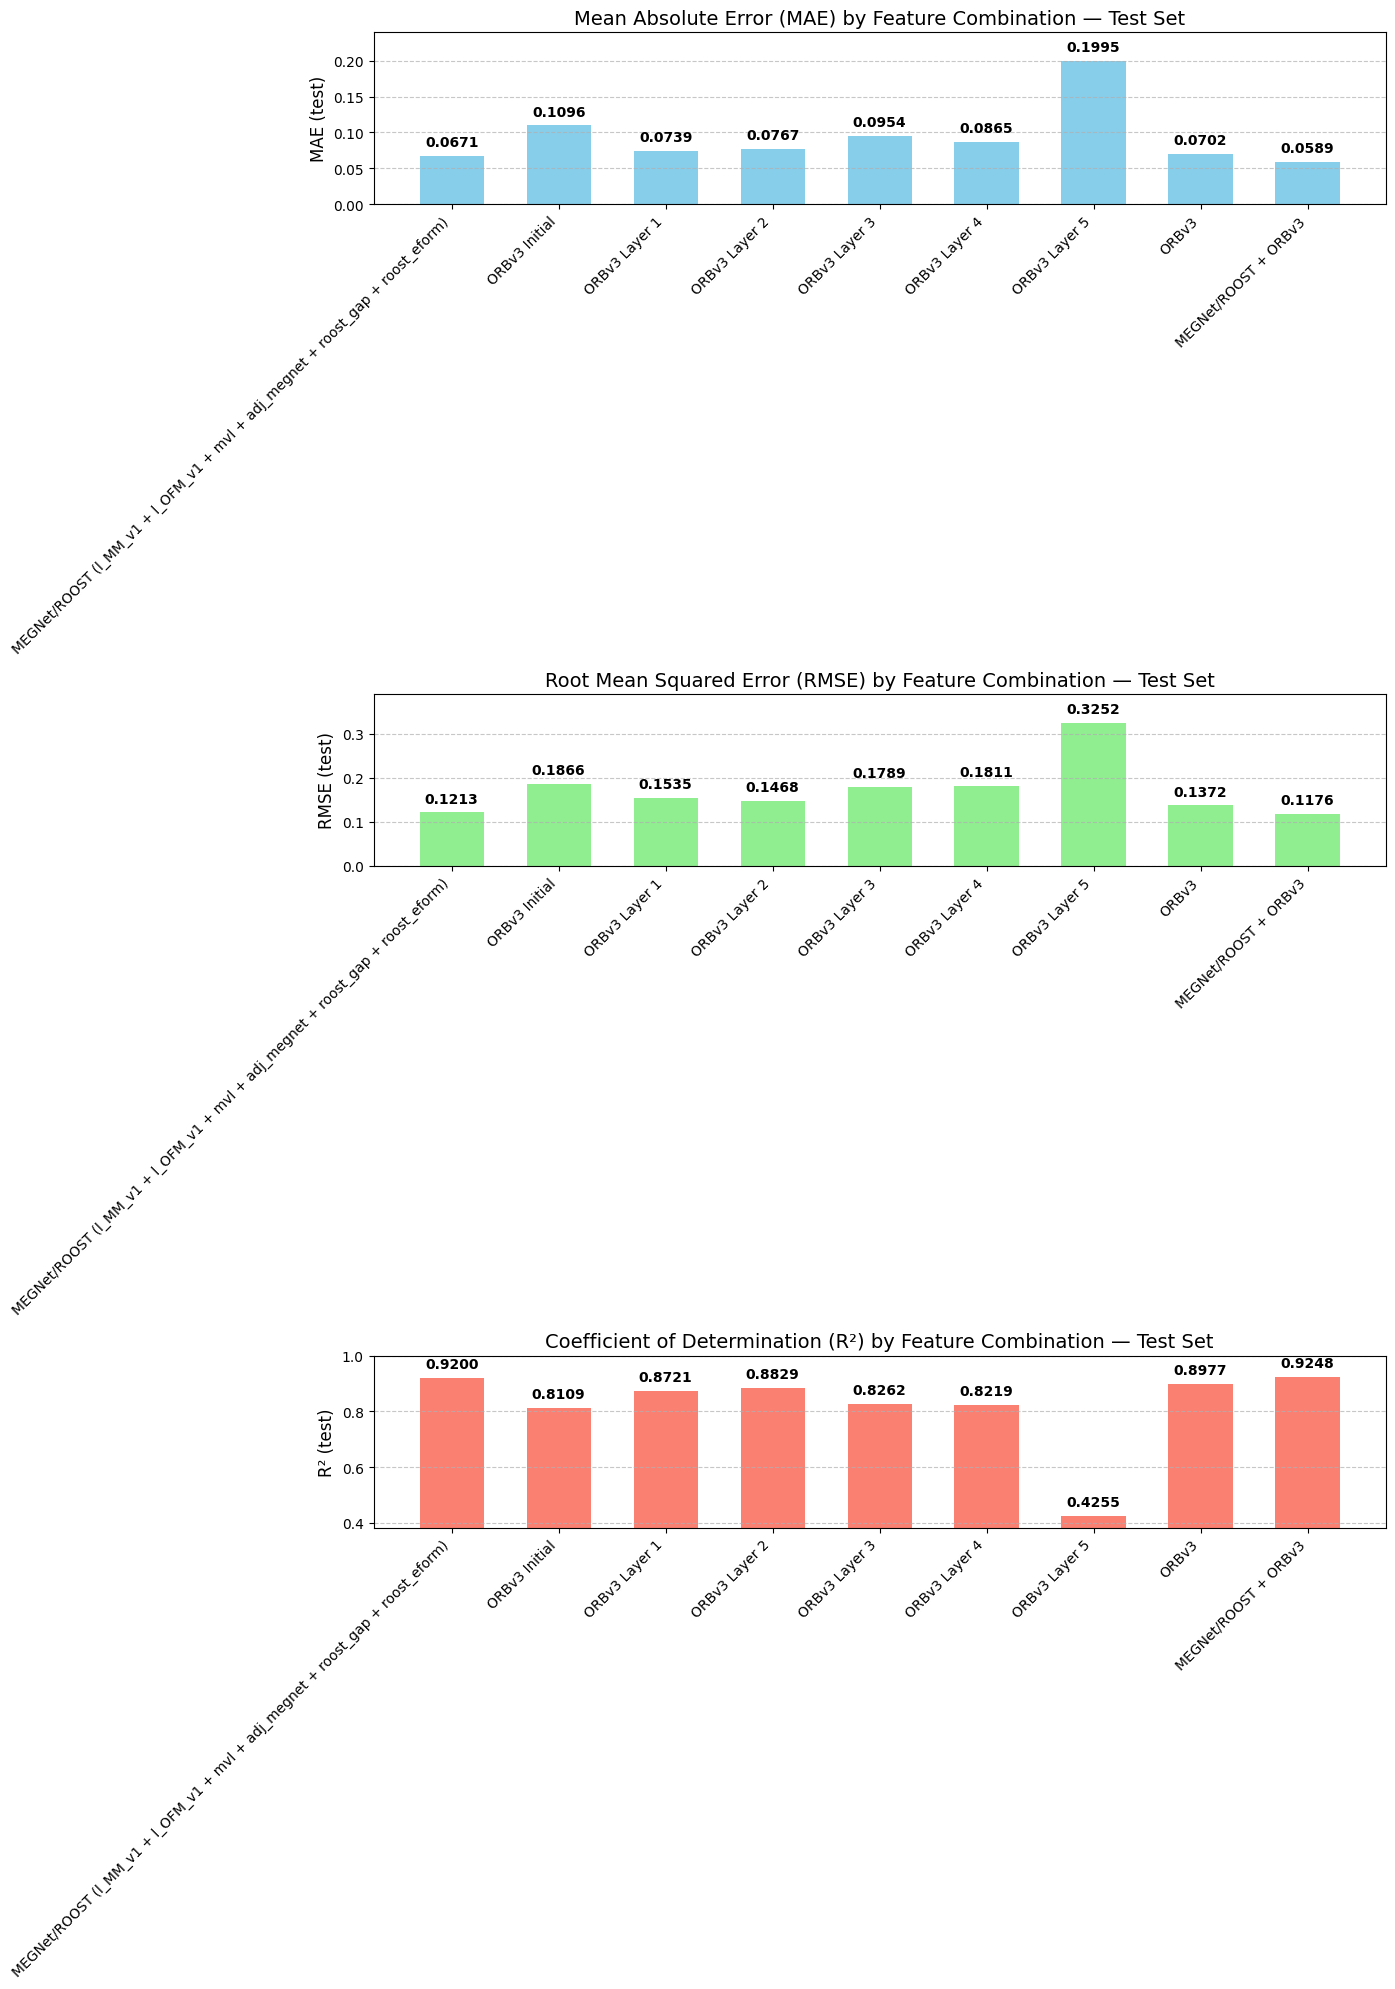

In [32]:
# Extract test-set data for plotting (all combinations are in metrics_df)
combinations = metrics_df['Combination'].astype(str)
mae = metrics_df['MAE_test'].values
rmse = metrics_df['RMSE_test'].values
r2 = metrics_df['R2_test'].values

# Number of feature combinations
num_combinations = len(combinations)
x = np.arange(num_combinations)  # the label locations
width = 0.6  # width of the bars (kept as before for same aesthetics)

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(14, 20))

# Function to add text annotations on top of bars
def add_text(ax, rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),  # 5 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10,
                    fontweight='bold')

# Plot MAE (test)
rects1 = axs[0].bar(x, mae, width, color='skyblue')
axs[0].set_ylabel('MAE (test)', fontsize=12)
axs[0].set_title('Mean Absolute Error (MAE) by Feature Combination — Test Set', fontsize=14)
axs[0].set_xticks(x)
axs[0].set_xticklabels(combinations, rotation=45, ha='right', fontsize=10)
axs[0].grid(axis='y', linestyle='--', alpha=0.7)
add_text(axs[0], rects1)
axs[0].set_ylim([0, max(mae) * 1.2])

# Plot RMSE (test)
rects2 = axs[1].bar(x, rmse, width, color='lightgreen')
axs[1].set_ylabel('RMSE (test)', fontsize=12)
axs[1].set_title('Root Mean Squared Error (RMSE) by Feature Combination — Test Set', fontsize=14)
axs[1].set_xticks(x)
axs[1].set_xticklabels(combinations, rotation=45, ha='right', fontsize=10)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)
add_text(axs[1], rects2)
axs[1].set_ylim([0, max(rmse) * 1.2])

# Plot R² (test)
rects3 = axs[2].bar(x, r2, width, color='salmon')
axs[2].set_ylabel('R² (test)', fontsize=12)
axs[2].set_title('Coefficient of Determination (R²) by Feature Combination — Test Set', fontsize=14)
axs[2].set_xticks(x)
axs[2].set_xticklabels(combinations, rotation=45, ha='right', fontsize=10)
axs[2].grid(axis='y', linestyle='--', alpha=0.7)
add_text(axs[2], rects3)
# Keep same style as before; ensure lower bound reasonable if R² can be negative
r2_min = r2.min()
axs[2].set_ylim([r2_min * 0.9 if r2_min < 0 else max(r2_min * 0.9, 0.0), 1.0])

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()

#### We can observe the benefit of leveraging all the layers of the ORB featurizer, and the synergetic effects to improve performance when we combine with the other featurizers.

Top 20 Most Important Features for the 'MEGNet/ROOST + ORBv3' model:
                            Feature  Importance
1257      AdjacentMEGNet_layer32_24    0.328534
1261      AdjacentMEGNet_layer32_28    0.247355
1270       AdjacentMEGNet_layer16_5    0.091154
1271       AdjacentMEGNet_layer16_6    0.047902
1246      AdjacentMEGNet_layer32_13    0.044959
1241       AdjacentMEGNet_layer32_8    0.016697
2087              ORB_v3_layer_1_38    0.010976
1272       AdjacentMEGNet_layer16_7    0.010247
1264      AdjacentMEGNet_layer32_31    0.007394
1245      AdjacentMEGNet_layer32_12    0.006719
1265      AdjacentMEGNet_layer32_32    0.006393
1282    ROOST_mpgap_LayerOutput_#01    0.006391
1279      AdjacentMEGNet_layer16_14    0.005526
2335              ORB_v3_layer_2_30    0.005289
1274       AdjacentMEGNet_layer16_9    0.005232
945        MEGNet_OFMEncoded_v1_188    0.004505
1004        MVL32_Efermi_MP_2019_27    0.003902
1147         MVL16_Eform_MP_2019_10    0.003749
437   MEGNet_MatMin

/tmp/ipykernel_1155281/553563769.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


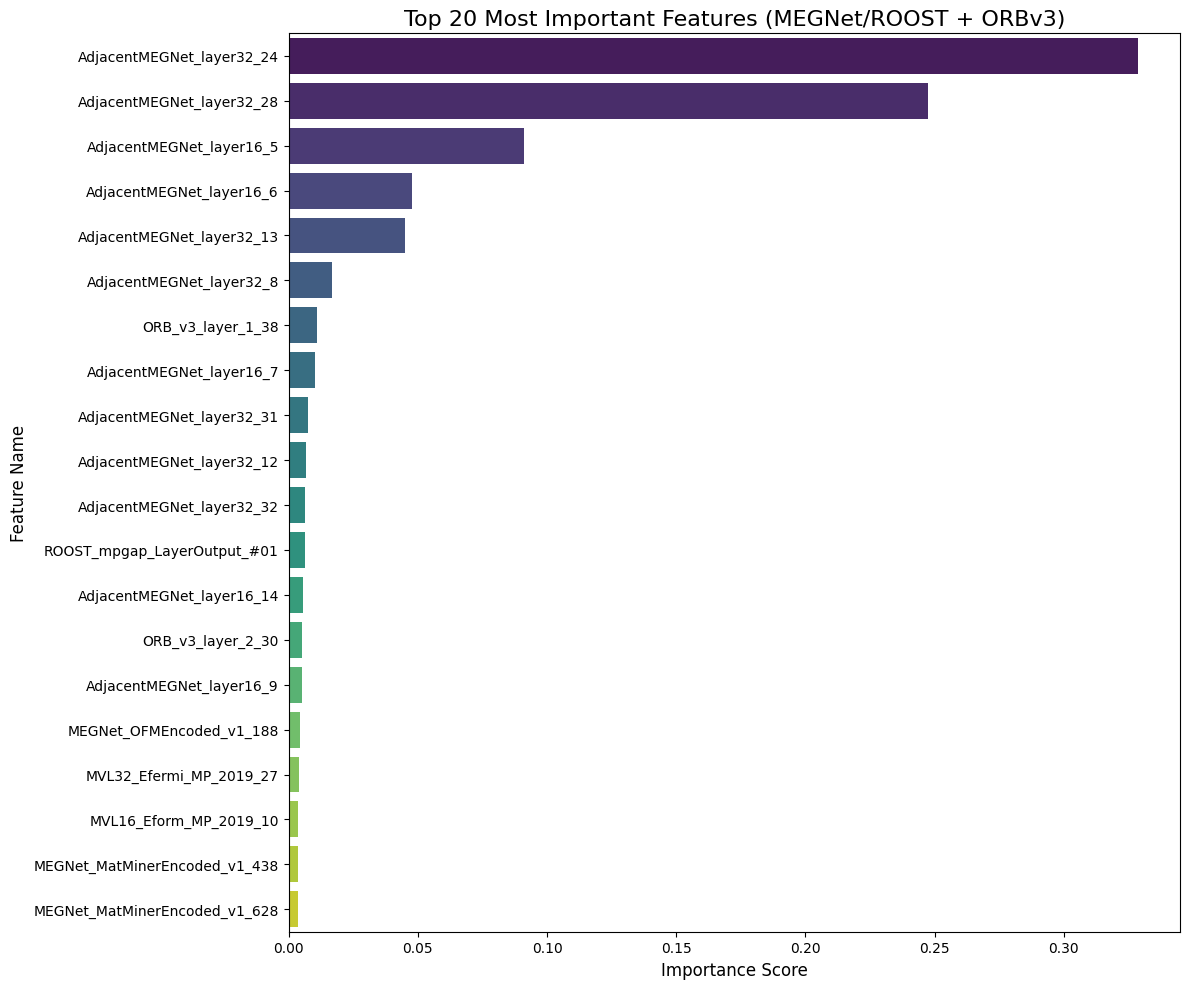

In [50]:
## Lets get the most important features for the latest model
# Create a DataFrame to hold the feature names and their importance scores
# The 'model' object and 'X_train' DataFrame from the last loop iteration are used here
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Sort the features by importance in descending order
sorted_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display the top 20 most important features
print("Top 20 Most Important Features for the 'MEGNet/ROOST + ORBv3' model:")
print(sorted_importances.head(20).to_string())

# --- Visualize the Top 20 Features ---
plt.figure(figsize=(12, 10))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=sorted_importances.head(20), 
    palette='viridis'
)
plt.title('Top 20 Most Important Features (MEGNet/ROOST + ORBv3)', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)
plt.tight_layout()
plt.show()

#### Here we exemplify the use of the Interpreter to get the corresponding formulas for the pretrained GNN features. 

In [ ]:
from mattervial.interpreter import Interpreter
interp = Interpreter.get_formula("ORB_v3_layer_1_38")
shap_data = interp.get_shap_values("MEGNet_MatMiner_1")